## Cell 1. cấu hình chung

In [ ]:
# Cell 1: Imports & global config
import os, cv2, numpy as np, tensorflow as tf
from collections import Counter
from typing import Tuple
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import AdamW

print("TensorFlow:", tf.__version__)
tf.get_logger().setLevel("ERROR") 


TensorFlow: 2.15.1


## Cell 2. Đường dẫn & siêu tham số

In [ ]:
DATA_DIR  = r"C:\Users\VACB\OneDrive\Desktop\eff\HoangAnh\chest_xray_v2"
TRAIN_DIR = os.path.join(DATA_DIR, "train")
VAL_DIR   = os.path.join(DATA_DIR, "val")
TEST_DIR  = os.path.join(DATA_DIR, "test")

IMG_SIZE  = (256, 256)   # tăng nhẹ so với 224
BATCH     = 32
EPOCHS_P1 = 30           
EPOCHS_P2 = 60         
NUM_CLASS = 3

OUT_DIR     = os.path.join(os.path.dirname(DATA_DIR), "ckpt_effb0_2")
os.makedirs(OUT_DIR, exist_ok=True)
BEST_PATH   = os.path.join(OUT_DIR, "effb0_best.h5")   
FINAL_PATH  = os.path.join(OUT_DIR, "effb0_final.h5")  
LOG_CSV     = os.path.join(OUT_DIR, "train_log.csv")   

## Cell 3. Tiền xử lý

In [ ]:
def clahe_enhance(img_rgb: np.ndarray) -> np.ndarray:
    #Làm rõ cấu trúc phổi bằng CLAHE (làm trên ảnh xám, trả về RGB).
    gray = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2GRAY)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    enhanced = clahe.apply(gray)
    return cv2.cvtColor(enhanced, cv2.COLOR_GRAY2RGB)

def preprocess_with_clahe(img_rgb: np.ndarray) -> np.ndarray:
    """Hàm đưa vào ImageDataGenerator.preprocessing_function."""
    img_rgb = clahe_enhance(img_rgb.astype(np.uint8))
    img_rgb = preprocess_input(img_rgb)  # chuẩn ImageNet 
    return img_rgb

## Cell 4. Data generators 

In [ ]:
train_gen = ImageDataGenerator(
    preprocessing_function=preprocess_with_clahe,
    rotation_range=10, width_shift_range=0.10, height_shift_range=0.10,
    zoom_range=0.10, shear_range=0.05,
    horizontal_flip=True, fill_mode="nearest"
)
valtest_gen = ImageDataGenerator(preprocessing_function=preprocess_with_clahe)

train_ds = train_gen.flow_from_directory(
    TRAIN_DIR, target_size=IMG_SIZE, batch_size=BATCH, class_mode="categorical"
)
val_ds = valtest_gen.flow_from_directory(
    VAL_DIR, target_size=IMG_SIZE, batch_size=BATCH, class_mode="categorical"
)
test_ds = valtest_gen.flow_from_directory(
    TEST_DIR, target_size=IMG_SIZE, batch_size=BATCH, class_mode="categorical", shuffle=False
)
print("Classes:", train_ds.class_indices)

Found 9097 images belonging to 3 classes.
Found 1359 images belonging to 3 classes.
Found 1355 images belonging to 3 classes.
Classes: {'NORMAL': 0, 'PNEUMONIA_bacteria': 1, 'PNEUMONIA_virus': 2}


## Cell 5. Class weight tránh lệch lớp

In [14]:
# Cell 5: Class weights (inverse frequency) — bỏ nếu dữ liệu cân bằng
counts = Counter(train_ds.classes)
total = sum(counts.values())
class_weight = {i: total/(NUM_CLASS*counts[i]) for i in counts}
print("Class counts:", counts)
print("Class weights:", class_weight)

Class counts: Counter({1: 3070, 0: 3026, 2: 3001})
Class weights: {0: 1.0020929720202687, 1: 0.9877307274701411, 2: 1.01044096412307}


# Cell 6. Xây head & compile 
(giai đoạn 1: freeze)

In [ ]:
base = EfficientNetB0(include_top=False, weights="imagenet", input_shape=IMG_SIZE + (3,))
base.trainable = False  # đóng băng backbone

x = GlobalAveragePooling2D()(base.output)
x = Dropout(0.40)(x)
x = Dense(256, activation="relu")(x)
x = Dropout(0.30)(x)
out = Dense(NUM_CLASS, activation="softmax")(x)
model = Model(base.input, out)

loss_fn = tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.05)
model.compile(optimizer=AdamW(learning_rate=1e-3, weight_decay=1e-5),
              loss=loss_fn, metrics=["accuracy"])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 rescaling_2 (Rescaling)     (None, 256, 256, 3)          0         ['input_2[0][0]']             
                                                                                                  
 normalization_1 (Normaliza  (None, 256, 256, 3)          7         ['rescaling_2[0][0]']         
 tion)                                                                                            
                                                                                                  
 rescaling_3 (Rescaling)     (None, 256, 256, 3)          0         ['normalization_1[0][0]'

## Cell 7. Callbacks

In [ ]:
from tensorflow.keras.callbacks import CSVLogger
callbacks = [
    ModelCheckpoint(BEST_PATH, monitor="val_accuracy", save_best_only=True, verbose=1),
    ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, verbose=1),
    EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True, verbose=1),
    CSVLogger(LOG_CSV, append=False)]

## Cell 8. Train Phase-1

In [ ]:
history1 = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS_P1,
    callbacks=callbacks,
    class_weight=class_weight)

Epoch 1/30
285/285 [==============================] - ETA: 0s - loss: 0.7077 - accuracy: 0.7105
Epoch 1: val_accuracy improved from -inf to 0.72553, saving model to C:\Users\VACB\OneDrive\Desktop\eff\ckpt_effb0_2\effb0_best.h5


c:\Users\VACB\OneDrive\Desktop\eff\.venv\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


285/285 [==============================] - 158s 544ms/step - loss: 0.7077 - accuracy: 0.7105 - val_loss: 0.6727 - val_accuracy: 0.7255 - lr: 0.0010
Epoch 2/30
285/285 [==============================] - ETA: 0s - loss: 0.6473 - accuracy: 0.7523
Epoch 2: val_accuracy improved from 0.72553 to 0.75791, saving model to C:\Users\VACB\OneDrive\Desktop\eff\ckpt_effb0_2\effb0_best.h5
285/285 [==============================] - 162s 568ms/step - loss: 0.6473 - accuracy: 0.7523 - val_loss: 0.6230 - val_accuracy: 0.7579 - lr: 0.0010
Epoch 3/30
285/285 [==============================] - ETA: 0s - loss: 0.6271 - accuracy: 0.7603
Epoch 3: val_accuracy did not improve from 0.75791
285/285 [==============================] - 155s 545ms/step - loss: 0.6271 - accuracy: 0.7603 - val_loss: 0.6459 - val_accuracy: 0.7461 - lr: 0.0010
Epoch 4/30
285/285 [==============================] - ETA: 0s - loss: 0.6189 - accuracy: 0.7651
Epoch 4: val_accuracy did not improve from 0.75791
285/285 [=======================

## Cell 9. Fine-tune Phase-2 (mở 40 lớp cuối)

In [ ]:
base.trainable = True
for layer in base.layers[:-40]:  
    layer.trainable = False

model.compile(optimizer=AdamW(learning_rate=1e-4, weight_decay=1e-5),
              loss=loss_fn, metrics=["accuracy"])

history2 = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS_P2,
    callbacks=callbacks,
    class_weight=class_weight)

Epoch 1/60
285/285 [==============================] - ETA: 0s - loss: 0.6168 - accuracy: 0.7711
Epoch 1: val_accuracy improved from 0.78440 to 0.78661, saving model to C:\Users\VACB\OneDrive\Desktop\eff\ckpt_effb0_2\effb0_best.h5
285/285 [==============================] - 164s 563ms/step - loss: 0.6168 - accuracy: 0.7711 - val_loss: 0.5670 - val_accuracy: 0.7866 - lr: 1.0000e-04
Epoch 2/60
285/285 [==============================] - ETA: 0s - loss: 0.5600 - accuracy: 0.8010
Epoch 2: val_accuracy improved from 0.78661 to 0.81604, saving model to C:\Users\VACB\OneDrive\Desktop\eff\ckpt_effb0_2\effb0_best.h5
285/285 [==============================] - 162s 569ms/step - loss: 0.5600 - accuracy: 0.8010 - val_loss: 0.5170 - val_accuracy: 0.8160 - lr: 1.0000e-04
Epoch 3/60
285/285 [==============================] - ETA: 0s - loss: 0.5342 - accuracy: 0.8161
Epoch 3: val_accuracy improved from 0.81604 to 0.81972, saving model to C:\Users\VACB\OneDrive\Desktop\eff\ckpt_effb0_2\effb0_best.h5
285/28

## Cell 10. Lưu mô hình

In [19]:
model.save(FINAL_PATH)

## Cell 11. Đánh giá trên file test

In [ ]:
best_model = load_model(BEST_PATH)
test_loss, test_acc = best_model.evaluate(test_ds, verbose=0)
print(f"Test Accuracy (BEST): {test_acc*100:.2f}% | Loss: {test_loss:.4f}")

Test Accuracy (BEST): 87.08% | Loss: 0.4704


## Cell 12. Classification Report

In [27]:
y_true = test_ds.classes
y_prob = best_model.predict(test_ds, verbose=0)
y_pred = np.argmax(y_prob, axis=1)

idx2cls = {v:k for k,v in test_ds.class_indices.items()}
labels = [idx2cls[i] for i in range(len(idx2cls))]

cm = confusion_matrix(y_true, y_pred)
print("Confusion matrix:\n", cm)
print("\nClassification report:")
print(classification_report(y_true, y_pred, target_names=labels, digits=4))

Confusion matrix:
 [[379  38  38]
 [  3 379  68]
 [  2  26 422]]

Classification report:
                    precision    recall  f1-score   support

            NORMAL     0.9870    0.8330    0.9035       455
PNEUMONIA_bacteria     0.8555    0.8422    0.8488       450
   PNEUMONIA_virus     0.7992    0.9378    0.8630       450

          accuracy                         0.8708      1355
         macro avg     0.8806    0.8710    0.8718      1355
      weighted avg     0.8810    0.8708    0.8719      1355



## Cell 13: Confusion Matrix

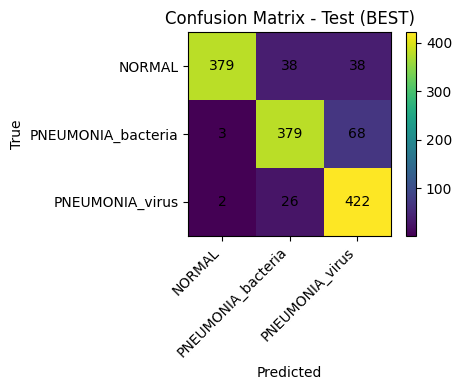

In [28]:
# Heatmap thuần matplotlib
fig, ax = plt.subplots(figsize=(5,4))
im = ax.imshow(cm, interpolation="nearest")
ax.set_title("Confusion Matrix - Test (BEST)")
ax.set_xticks(range(len(labels))); ax.set_yticks(range(len(labels)))
ax.set_xticklabels(labels, rotation=45, ha="right"); ax.set_yticklabels(labels)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, cm[i, j], ha="center", va="center")
plt.xlabel("Predicted"); plt.ylabel("True")
plt.colorbar(im); plt.tight_layout(); plt.show()

## Cell 14. ROC-AUC

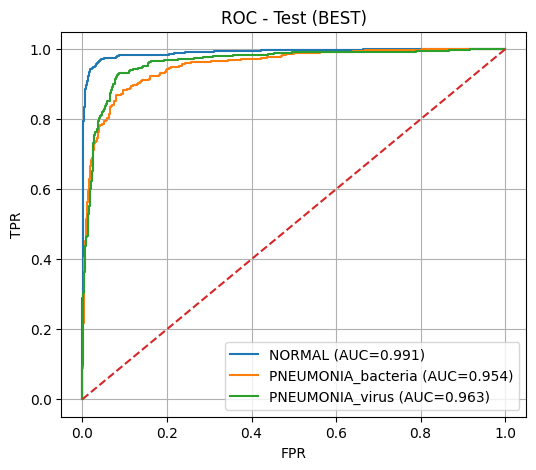

In [ ]:
plt.figure(figsize=(6,5))
for i, name in enumerate(labels):
    fpr, tpr, _ = roc_curve((y_true==i).astype(int), y_prob[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{name} (AUC={roc_auc:.3f})")
plt.plot([0,1],[0,1], linestyle="--")
plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title("ROC - Test (BEST)")
plt.legend(); plt.grid(True)
plt.show()

# Cell 15. Grad-CAM để kiểm chứng vùng học
## Hàm Gradcam và kiểm thử

1. HÀM PICK LỚP CONV CUỐI

In [42]:
import tensorflow as tf
# Tìm tên lớp convolution cuối cùng trong mô hình-dùng cho gradcam vì cần layer cuối có tensor 4 chiều (H, W, C)
def pick_last_conv(m: tf.keras.Model, fallback="top_conv") -> str:
    try:
        m.get_layer(fallback)
        return fallback
    except: #  # nếu không có lớp tên đó, dò ngược từ cuối lên để tìm lớp conv 4d
        for layer in reversed(m.layers):
            shp = getattr(layer, "output_shape", None)
            if isinstance(shp, tuple) and len(shp)==4:
                return layer.name
        raise ValueError("Hông tìm thấy lớp conv 4D cuối.")

2. HÀM TẠO BẢN NHIỆT GRAD-CAM

In [ ]:
def make_gradcam_heatmap(img_batch, m: tf.keras.Model, last_conv_name: str):
# lấy layer conv cuối và tạo model phụ đầu ra = (conv_output, prediction)
    last_conv = m.get_layer(last_conv_name)
    grad_model = tf.keras.models.Model(m.inputs, [last_conv.output, m.output])
    with tf.GradientTape() as tape:
        conv_out, preds = grad_model(img_batch, training=False)
        class_idx = tf.argmax(preds[0])
        score = preds[:, class_idx]
# Tính gradient của output theo feature map
    grads = tape.gradient(score, conv_out)
    pooled = tf.reduce_mean(grads, axis=(0,1,2))
    conv_out = conv_out[0]
# Kết hợp trọng số * feature map để tạo bản nhiệt
    heatmap = tf.reduce_sum(tf.multiply(pooled, conv_out), axis=-1)
# Chuẩn hóa về 0-1 để hiển thị
    heatmap = tf.maximum(heatmap, 0) / (tf.reduce_max(heatmap) + 1e-8)
    return heatmap.numpy()

3. HÀM CHỒNG MÀU HEATMAP LÊN ẢNH GỐC

In [ ]:
def overlay_heatmap(img_rgb, heatmap, alpha=0.5):
    hm = cv2.resize((heatmap*255).astype(np.uint8), (img_rgb.shape[1], img_rgb.shape[0]))
# Tô màu JET
    hm = cv2.applyColorMap(hm, cv2.COLORMAP_JET)[:, :, ::-1]
    return (alpha*hm + (1-alpha)*img_rgb).astype(np.uint8)

4. KIỂM THỬ VỚI 20 ẢNH TEST

Last conv: top_conv


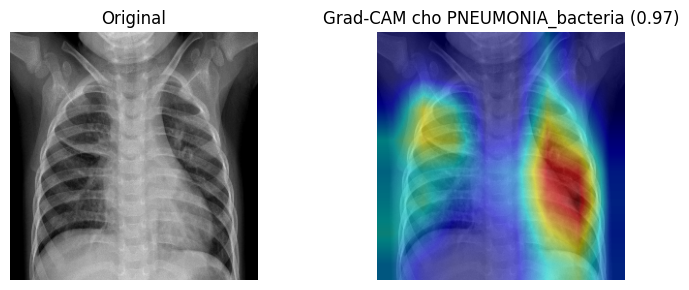

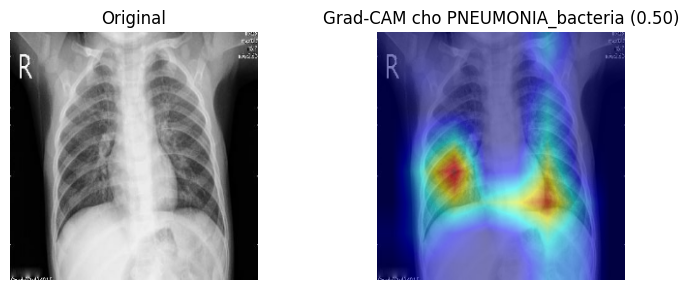

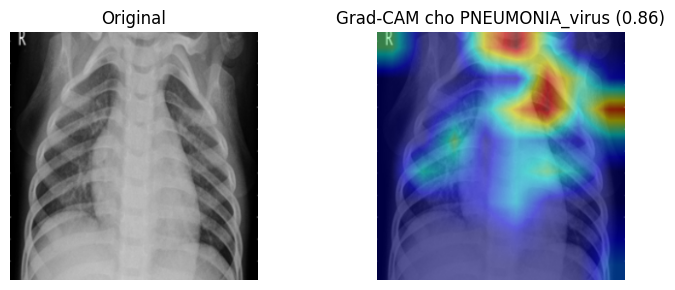

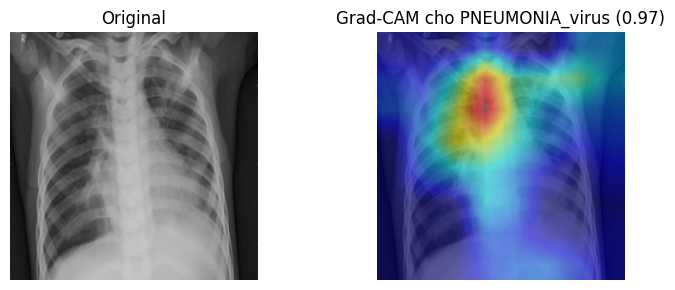

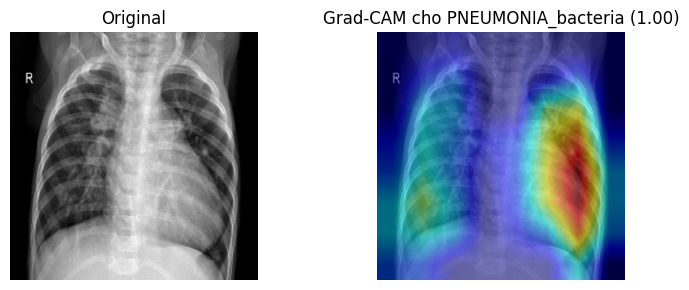

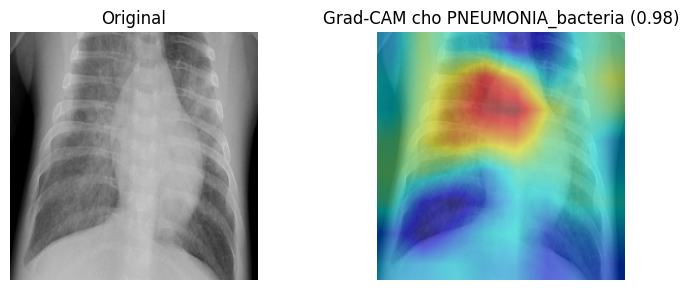

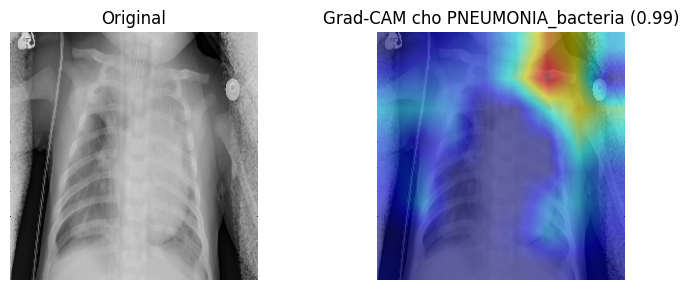

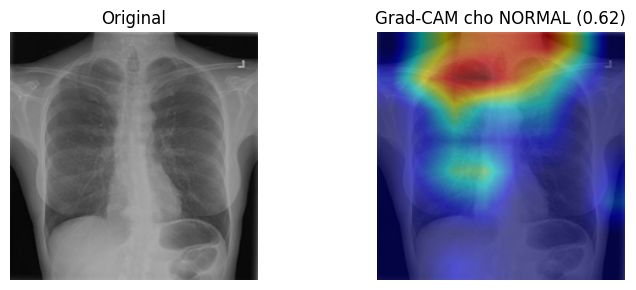

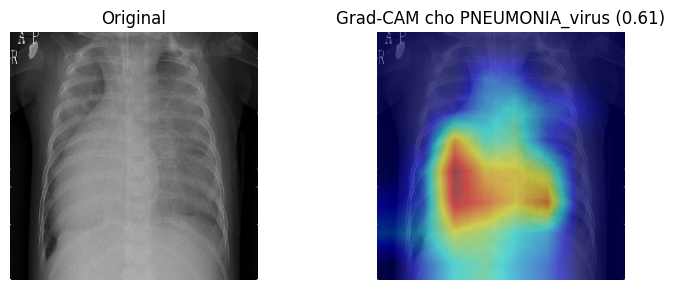

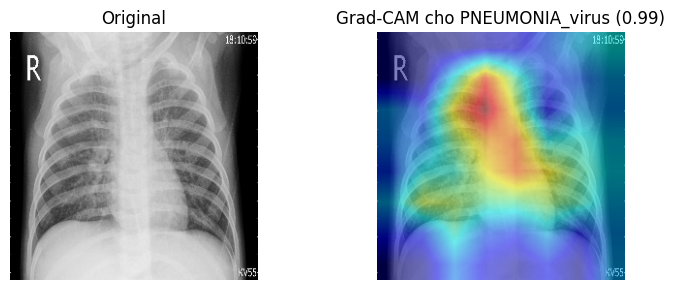

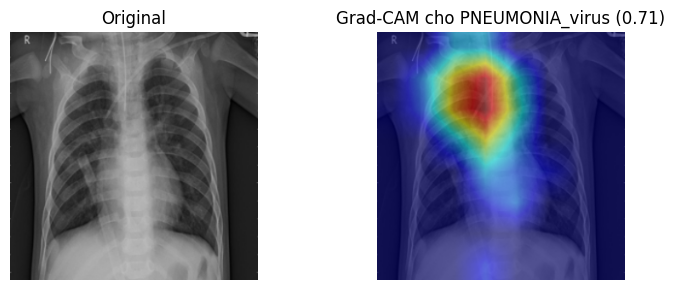

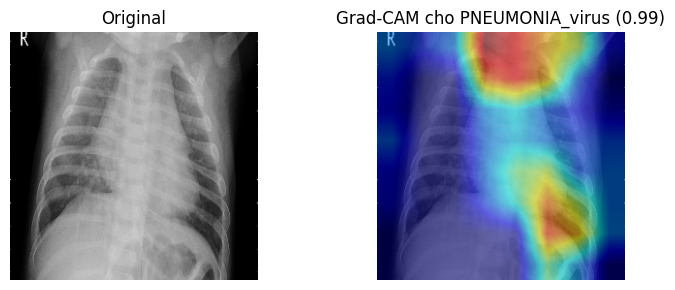

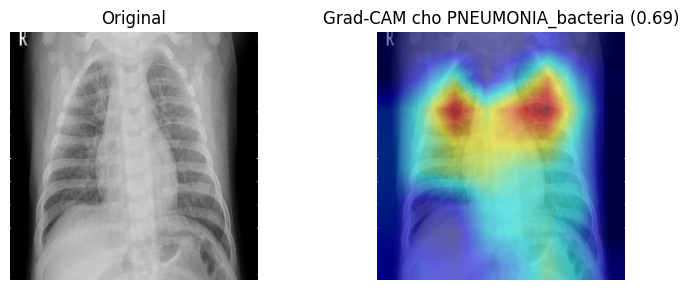

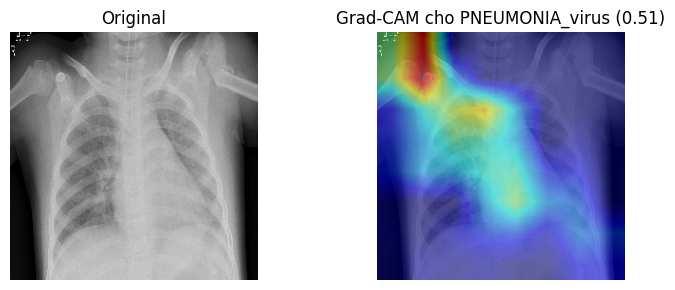

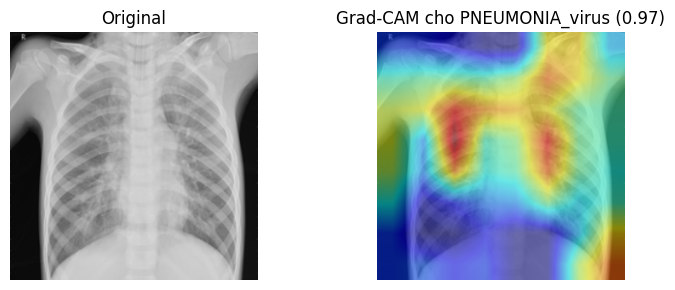

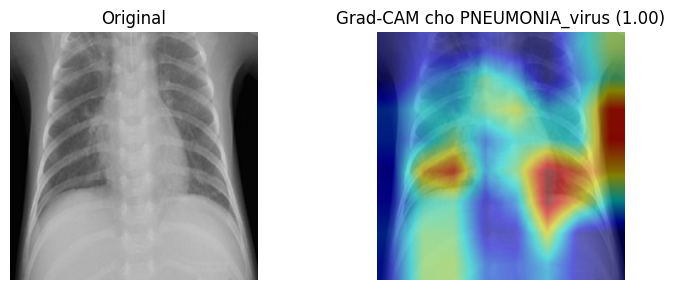

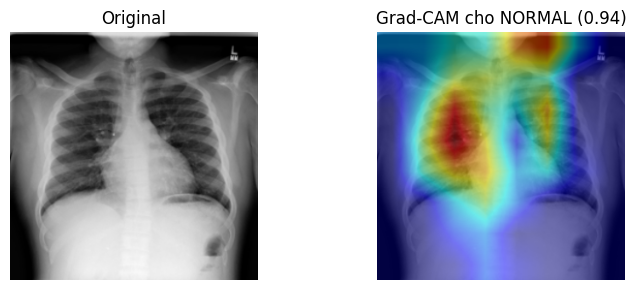

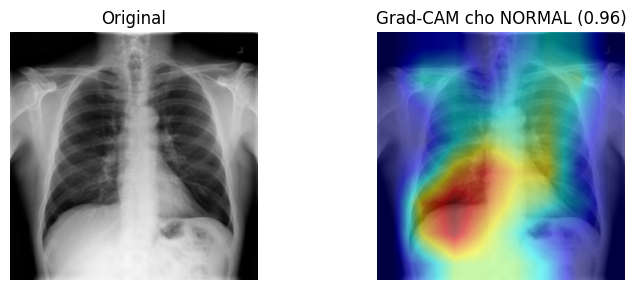

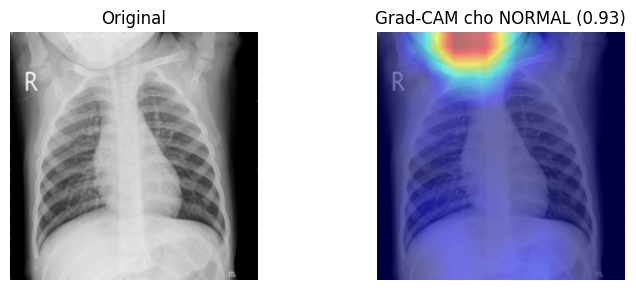

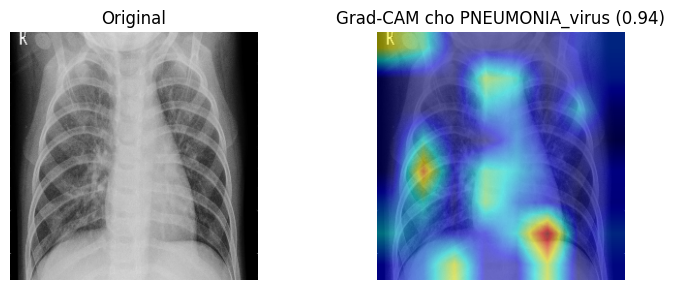

In [45]:
np.random.seed(0)
idxs = np.random.choice(len(test_ds.filenames), size=min(20, len(test_ds.filenames)), replace=False)

last_conv = pick_last_conv(best_model, fallback="top_conv")
print("Last conv:", last_conv)

for idx in idxs:
    path = os.path.join(TEST_DIR, test_ds.filenames[idx])
    bgr = cv2.imread(path); rgb = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)
    rgb_resized = cv2.resize(rgb, IMG_SIZE)

    inp = preprocess_with_clahe(rgb_resized.copy())
    inp = np.expand_dims(inp, 0)

    heat = make_gradcam_heatmap(inp, best_model, last_conv)
    overlay = overlay_heatmap(rgb_resized, heat)

    prob = best_model.predict(inp, verbose=0)[0]
    pred_id = int(np.argmax(prob))
    pred_name = [k for k,v in test_ds.class_indices.items() if v==pred_id][0]
    conf = float(prob[pred_id])

    import matplotlib.pyplot as plt
    plt.figure(figsize=(8,3))
    plt.subplot(1,2,1); plt.imshow(rgb_resized); plt.title("Original"); plt.axis("off")
    plt.subplot(1,2,2); plt.imshow(overlay); plt.title(f"Grad-CAM cho {pred_name} ({conf:.2f})"); plt.axis("off")
    plt.tight_layout(); plt.show()

# Cell 16. Cấu hình đầu ra & tạo thư mục
## Mục tiêu tạo file ảnh chứa tỉ lệ dự đoán và kèm gradcam cho mỗi bức ảnh trong mục test

1. Cấu hình đầu ra & tham số

In [21]:
# Thư mục lưu cặp ảnh
OUT_PAIRS = os.path.join(os.path.dirname(DATA_DIR), "gradcam_pairs")
os.makedirs(OUT_PAIRS, exist_ok=True)

# Tham số bạn có thể chỉnh
PAIR_DPI = 180          # độ nét ảnh ghép khi lưu bằng matplotlib
GC_ALPHA = 0.5          # độ trong suốt khi overlay heatmap
LIMIT_PER_CLASS = None  # None = xuất tất cả; hoặc đặt số (vd 100) để test nhanh

print("Output:", OUT_PAIRS)
print("Params  →  dpi:", PAIR_DPI, "| alpha:", GC_ALPHA, "| limit:", LIMIT_PER_CLASS)

Output: C:\Users\VACB\OneDrive\Desktop\eff\gradcam_pairs
Params  →  dpi: 180 | alpha: 0.5 | limit: None


2. Chọn best_model và lớp conv cuố

In [22]:
mdl = best_model  
last_conv = pick_last_conv(mdl, fallback="top_conv")
print("Using BEST model.  Last conv:", last_conv)

Using BEST model.  Last conv: top_conv


3. Chuẩn bị danh sách ảnh test & ánh xạ lớp

In [23]:
idx2cls = {v: k for k, v in test_ds.class_indices.items()}   
classes = list(test_ds.class_indices.keys())                 
y_true  = test_ds.classes                                     # vector nhãn thật 
filelist = [os.path.join(TEST_DIR, fp) for fp in test_ds.filenames]

# Tạo sẵn thư mục class/correct & class/wrong
for c in classes:
    os.makedirs(os.path.join(OUT_PAIRS, c, "correct"), exist_ok=True)
    os.makedirs(os.path.join(OUT_PAIRS, c, "wrong"),   exist_ok=True)

print("Classes:", classes)
print("Total test images:", len(filelist))

Classes: ['NORMAL', 'PNEUMONIA_bacteria', 'PNEUMONIA_virus']
Total test images: 1355


4. Hàm tạo ảnh

In [ ]:
import cv2, numpy as np, matplotlib.pyplot as plt

def build_pair_image_and_save(src_path: str, true_name: str,model, last_conv: str, save_root: str, alpha: float = 0.5, dpi: int = 180):
    # đọc ảnh
    bgr = cv2.imread(src_path)
    if bgr is None:
        return None
    rgb = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)
    rgb_resized = cv2.resize(rgb, IMG_SIZE)

    # dự đoán
    inp  = preprocess_with_clahe(rgb_resized.copy())[None, ...]
    prob = model.predict(inp, verbose=0)[0]
    pred_id = int(np.argmax(prob))
    pred_name = idx2cls[pred_id]
    conf = float(prob[pred_id])
    correct = (pred_name == true_name)

    # grad-cam overlay
    heat = make_gradcam_heatmap(inp, model, last_conv)
    overlay = overlay_heatmap(rgb_resized, heat, alpha=alpha)

    # vẽ 2 cột và lưu (để có tiêu đề đẹp)
    subdir = "correct" if correct else "wrong"
    out_dir = os.path.join(save_root, true_name, subdir)
    os.makedirs(out_dir, exist_ok=True)
    base = os.path.splitext(os.path.basename(src_path))[0]
    out_path = os.path.join(out_dir, f"{base}_pair.jpg")

    # vẽ
    fig_w = max(8, int((2*IMG_SIZE[0]/IMG_SIZE[1])*4))  # tính tỉ lệ hình ngang
    fig, axs = plt.subplots(1, 2, figsize=(fig_w, 4))
    axs[0].imshow(rgb_resized); axs[0].set_title("Original"); axs[0].axis("off")
    axs[1].imshow(overlay);     axs[1].set_title(f"Grad-CAM → {pred_name} ({conf:.2f})"); axs[1].axis("off")
    plt.tight_layout()
    plt.savefig(out_path, dpi=dpi, bbox_inches="tight")
    plt.close(fig)

    return pred_name, conf, correct, out_path

5. Vòng lặp toàn bộ test

In [25]:
written_per_class = {c: 0 for c in classes}
saved_count = 0

for i, src in enumerate(filelist):
    true_name = idx2cls[int(y_true[i])]

    #limit mỗi lớp 
    if isinstance(LIMIT_PER_CLASS, int) and written_per_class[true_name] >= LIMIT_PER_CLASS:
        continue
    res = build_pair_image_and_save(src, true_name, mdl, last_conv, save_root=OUT_PAIRS, alpha=GC_ALPHA, dpi=PAIR_DPI)
    if res is None:
        continue
    
    pred_name, conf, correct, out_path = res
    written_per_class[true_name] += 1
    saved_count += 1
    # progress nhẹ
    if (i+1) % 100 == 0 or (i+1) == len(filelist):
        print(f"... processed {i+1}/{len(filelist)} | saved {saved_count}")

print("Đã lưu xong:", OUT_PAIRS)

... processed 100/1355 | saved 100
... processed 200/1355 | saved 200
... processed 300/1355 | saved 300
... processed 400/1355 | saved 400
... processed 500/1355 | saved 500
... processed 600/1355 | saved 600
... processed 700/1355 | saved 700
... processed 800/1355 | saved 800
... processed 900/1355 | saved 900
... processed 1000/1355 | saved 1000
... processed 1100/1355 | saved 1100
... processed 1200/1355 | saved 1200
... processed 1300/1355 | saved 1300
... processed 1355/1355 | saved 1355
Đã lưu xong: C:\Users\VACB\OneDrive\Desktop\eff\gradcam_pairs


## Cell 17: Xác thực chéo stratified K-Fold

1. thư viện bổ sung

In [2]:
import os, pandas as pd
from sklearn.model_selection import StratifiedKFold
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.models import load_model

In [ ]:
DATA_DIR  = r"C:\Users\VACB\OneDrive\Desktop\eff\chest_xray_v2"
TRAIN_DIR = os.path.join(DATA_DIR, "train")
VAL_DIR   = os.path.join(DATA_DIR, "val")
TEST_DIR  = os.path.join(DATA_DIR, "test")

for d in [DATA_DIR, TRAIN_DIR, VAL_DIR, TEST_DIR]:
    print(f"{'OK ' if os.path.isdir(d) else 'NO!'}  {d}")
    if not os.path.isdir(d):
        print("→ Folder không tồn tại, kiểm tra lại đường dẫn ở trên."); 

OK   C:\Users\VACB\OneDrive\Desktop\eff\chest_xray_v2
OK   C:\Users\VACB\OneDrive\Desktop\eff\chest_xray_v2\train
OK   C:\Users\VACB\OneDrive\Desktop\eff\chest_xray_v2\val
OK   C:\Users\VACB\OneDrive\Desktop\eff\chest_xray_v2\test


2. Gom dữ liệu train/ + val/ 

In [ ]:
def list_images_with_labels(root_dir):
    rows = []
    for cls in sorted(os.listdir(root_dir)):
        cls_dir = os.path.join(root_dir, cls)
        if not os.path.isdir(cls_dir):
            continue
        for fn in os.listdir(cls_dir):
            fp = os.path.join(cls_dir, fn)
            if os.path.isfile(fp) and fn.lower().endswith((".png", ".jpg", ".jpeg")):
                rows.append({"path": fp, "label": cls})
    return rows

df_train = pd.DataFrame(list_images_with_labels(TRAIN_DIR))
df_val   = pd.DataFrame(list_images_with_labels(VAL_DIR))
df_all   = pd.concat([df_train, df_val], ignore_index=True)

print("tổng ảnh train:", len(df_train), " | val:", len(df_val), " | gộp:", len(df_all))
print(df_all.head())

tổng ảnh train: 9097  | val: 1359  | gộp: 10456
                                                path   label
0  C:\Users\VACB\OneDrive\Desktop\eff\chest_xray_...  NORMAL
1  C:\Users\VACB\OneDrive\Desktop\eff\chest_xray_...  NORMAL
2  C:\Users\VACB\OneDrive\Desktop\eff\chest_xray_...  NORMAL
3  C:\Users\VACB\OneDrive\Desktop\eff\chest_xray_...  NORMAL
4  C:\Users\VACB\OneDrive\Desktop\eff\chest_xray_...  NORMAL


3. Tạo K folds cân bằng nhãn 

In [12]:
IMG_SIZE = (256, 256)
BATCH = 32

K = 3
skf = StratifiedKFold(n_splits=K, shuffle=True, random_state=42)

# ánh xạ tên lớp ↔ chỉ số
classes = sorted(df_all["label"].unique())
class_to_idx = {c:i for i,c in enumerate(classes)}
idx_to_class = {i:c for c,i in class_to_idx.items()}
y_all = df_all["label"].map(class_to_idx).values

print("Classes:", classes)

Classes: ['NORMAL', 'PNEUMONIA_bacteria', 'PNEUMONIA_virus']


In [13]:
import cv2
import numpy as np
from tensorflow.keras.applications.efficientnet import preprocess_input

# Bảo đảm các biến chung tồn tại
IMG_SIZE = IMG_SIZE if 'IMG_SIZE' in globals() else (256, 256)

def clahe_enhance(img_rgb: np.ndarray) -> np.ndarray:
    """Tăng tương phản cấu trúc phổi bằng CLAHE (làm trên ảnh xám, trả về RGB)."""
    gray = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2GRAY)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    enhanced = clahe.apply(gray)
    return cv2.cvtColor(enhanced, cv2.COLOR_GRAY2RGB)

def preprocess_with_clahe(img_rgb: np.ndarray) -> np.ndarray:
    """Hàm dùng cho ImageDataGenerator.preprocessing_function."""
    img_rgb = clahe_enhance(img_rgb.astype(np.uint8))
    return preprocess_input(img_rgb)

4. Tạo generators từ DataFrame cho từng fold

In [14]:
train_gen = ImageDataGenerator(
    preprocessing_function=preprocess_with_clahe,
    rotation_range=10, width_shift_range=0.10, height_shift_range=0.10,
    zoom_range=0.10, shear_range=0.05,
    horizontal_flip=True, fill_mode="nearest"
)
val_gen = ImageDataGenerator(preprocessing_function=preprocess_with_clahe)

def make_df_generators(df_all, train_idx, val_idx, img_size, batch, class_mode="categorical"):
    df_tr = df_all.iloc[train_idx].copy()
    df_va = df_all.iloc[val_idx].copy()
    classes_sorted = sorted(df_all["label"].unique())

    tr_ds = train_gen.flow_from_dataframe(
        dataframe=df_tr,
        directory=None,          
        x_col="path",
        y_col="label",
        target_size=img_size,
        classes=classes_sorted,    
        batch_size=batch,
        class_mode=class_mode,
        shuffle=True,
        seed=42,
        validate_filenames=False
    )
    va_ds = val_gen.flow_from_dataframe(
        dataframe=df_va,
        directory=None,
        x_col="path",
        y_col="label",
        target_size=img_size,
        classes=classes_sorted,
        batch_size=batch,
        class_mode=class_mode,
        shuffle=False,
        validate_filenames=False
    )
    return tr_ds, va_ds

5. Model factory & callbacks cho mỗi fold

In [15]:
CV_OUT_DIR = os.path.join(os.path.dirname(DATA_DIR), "cv_effb0")
os.makedirs(CV_OUT_DIR, exist_ok=True)

def build_effb0(num_classes=3, input_shape=IMG_SIZE+(3,), lr=1e-3):
    base = EfficientNetB0(include_top=False, weights="imagenet", input_shape=input_shape)
    base.trainable = False
    x = GlobalAveragePooling2D()(base.output)
    x = Dropout(0.40)(x)
    x = Dense(256, activation="relu")(x)
    x = Dropout(0.30)(x)
    out = Dense(num_classes, activation="softmax")(x)
    model = Model(base.input, out)
    loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.05)
    model.compile(optimizer=AdamW(learning_rate=lr, weight_decay=1e-5),
                  loss=loss, metrics=["accuracy"])
    return model, base

def fold_callbacks(fold_dir):
    os.makedirs(fold_dir, exist_ok=True)
    best_path = os.path.join(fold_dir, "best.h5")
    cbs = [
        ModelCheckpoint(best_path, monitor="val_accuracy", save_best_only=True, verbose=1),
        ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, verbose=1),
        EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True, verbose=1),
    ]
    return cbs

6. Vòng lặp huấn luyện theo fold

In [16]:
fold_metrics = []   # lưu (fold, best_val_acc, best_path)
for fold, (tr_idx, va_idx) in enumerate(skf.split(df_all["path"].values, y_all), start=1):
    print(f"\n FOLD {fold}/{K}")
    fold_dir = os.path.join(CV_OUT_DIR, f"fold_{fold:02d}")
    tr_ds, va_ds = make_df_generators(df_all, tr_idx, va_idx, IMG_SIZE, BATCH)

    # Phase-1 (freeze)
    model, base = build_effb0(num_classes=len(classes), input_shape=IMG_SIZE+(3,), lr=1e-3)
    cbs = fold_callbacks(fold_dir)
    model.fit(
        tr_ds, validation_data=va_ds,
        epochs=10, callbacks=cbs, verbose=1
    )

    # Phase-2 (fine-tune mở 20 lớp cuối)
    base.trainable = True
    for l in base.layers[:-20]:
        l.trainable = False
    model.compile(optimizer=AdamW(learning_rate=1e-4, weight_decay=1e-5), loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.05), metrics=["accuracy"])
    model.fit(
        tr_ds, validation_data=va_ds,
        epochs=10, callbacks=cbs, verbose=1
    )

    # Load best và đo val_acc tốt nhất của fold
    best_path = os.path.join(fold_dir, "best.h5")
    best_m = load_model(best_path, custom_objects={"AdamW": AdamW})
    val_loss, val_acc = best_m.evaluate(va_ds, verbose=0)
    print(f"FOLD {fold}  →  Best val_acc = {val_acc:.4f} | saved: {best_path}")
    fold_metrics.append((fold, val_acc, best_path))

print("\n hoàn tất.")


 FOLD 1/3
Found 6970 non-validated image filenames belonging to 3 classes.
Found 3486 non-validated image filenames belonging to 3 classes.


Epoch 1/10


218/218 [==============================] - ETA: 0s - loss: 0.7266 - accuracy: 0.7053
Epoch 1: val_accuracy improved from -inf to 0.77051, saving model to C:\Users\VACB\OneDrive\Desktop\eff\cv_effb0\fold_01\best.h5


c:\Users\VACB\OneDrive\Desktop\eff\.venv\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


218/218 [==============================] - 306s 1s/step - loss: 0.7266 - accuracy: 0.7053 - val_loss: 0.6180 - val_accuracy: 0.7705 - lr: 0.0010
Epoch 2/10
218/218 [==============================] - ETA: 0s - loss: 0.6496 - accuracy: 0.7475
Epoch 2: val_accuracy did not improve from 0.77051
218/218 [==============================] - 149s 684ms/step - loss: 0.6496 - accuracy: 0.7475 - val_loss: 0.6295 - val_accuracy: 0.7593 - lr: 0.0010
Epoch 3/10
218/218 [==============================] - ETA: 0s - loss: 0.6291 - accuracy: 0.7659
Epoch 3: val_accuracy improved from 0.77051 to 0.78543, saving model to C:\Users\VACB\OneDrive\Desktop\eff\cv_effb0\fold_01\best.h5
218/218 [==============================] - 154s 705ms/step - loss: 0.6291 - accuracy: 0.7659 - val_loss: 0.5874 - val_accuracy: 0.7854 - lr: 0.0010
Epoch 4/10
218/218 [==============================] - ETA: 0s - loss: 0.6193 - accuracy: 0.7707
Epoch 4: val_accuracy did not improve from 0.78543
218/218 [============================

c:\Users\VACB\OneDrive\Desktop\eff\.venv\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 2/10
218/218 [==============================] - ETA: 0s - loss: 0.6493 - accuracy: 0.7531
Epoch 2: val_accuracy improved from 0.75237 to 0.78020, saving model to C:\Users\VACB\OneDrive\Desktop\eff\cv_effb0\fold_02\best.h5
218/218 [==============================] - 151s 692ms/step - loss: 0.6493 - accuracy: 0.7531 - val_loss: 0.5955 - val_accuracy: 0.7802 - lr: 0.0010
Epoch 3/10
218/218 [==============================] - ETA: 0s - loss: 0.6336 - accuracy: 0.7653
Epoch 3: val_accuracy did not improve from 0.78020
218/218 [==============================] - 152s 696ms/step - loss: 0.6336 - accuracy: 0.7653 - val_loss: 0.5943 - val_accuracy: 0.7768 - lr: 0.0010
Epoch 4/10
218/218 [==============================] - ETA: 0s - loss: 0.6188 - accuracy: 0.7683
Epoch 4: val_accuracy did not improve from 0.78020
218/218 [==============================] - 148s 680ms/step - loss: 0.6188 - accuracy: 0.7683 - val_loss: 0.5880 - val_accuracy: 0.7776 - lr: 0.0010
Epoch 5/10
218/218 [==============

c:\Users\VACB\OneDrive\Desktop\eff\.venv\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 2/10
218/218 [==============================] - ETA: 0s - loss: 0.6488 - accuracy: 0.7451
Epoch 2: val_accuracy improved from 0.73888 to 0.77762, saving model to C:\Users\VACB\OneDrive\Desktop\eff\cv_effb0\fold_03\best.h5
218/218 [==============================] - 168s 772ms/step - loss: 0.6488 - accuracy: 0.7451 - val_loss: 0.5932 - val_accuracy: 0.7776 - lr: 0.0010
Epoch 3/10
218/218 [==============================] - ETA: 0s - loss: 0.6248 - accuracy: 0.7663
Epoch 3: val_accuracy did not improve from 0.77762
218/218 [==============================] - 261s 1s/step - loss: 0.6248 - accuracy: 0.7663 - val_loss: 0.6429 - val_accuracy: 0.7455 - lr: 0.0010
Epoch 4/10
218/218 [==============================] - ETA: 0s - loss: 0.6268 - accuracy: 0.7613
Epoch 4: val_accuracy did not improve from 0.77762
218/218 [==============================] - 215s 986ms/step - loss: 0.6268 - accuracy: 0.7613 - val_loss: 0.6191 - val_accuracy: 0.7527 - lr: 0.0010
Epoch 5/10
218/218 [=================

7. Tổng hợp kết quả CV và chọn fold tốt nhất

In [17]:
import numpy as np, pandas as pd

df_cv = pd.DataFrame(fold_metrics, columns=["fold", "val_acc", "best_path"])
mean_acc = df_cv["val_acc"].mean()
std_acc  = df_cv["val_acc"].std()
best_row = df_cv.loc[df_cv["val_acc"].idxmax()]
print(df_cv)
print(f"\n Mean val_acc = {mean_acc:.4f}  ±  {std_acc:.4f}")
print(f" Best fold = {int(best_row.fold)}  |  val_acc = {best_row.val_acc:.4f}")
print("Best model path:", best_row.best_path)

   fold   val_acc                                          best_path
0     1  0.851406  C:\Users\VACB\OneDrive\Desktop\eff\cv_effb0\fo...
1     2  0.839024  C:\Users\VACB\OneDrive\Desktop\eff\cv_effb0\fo...
2     3  0.851650  C:\Users\VACB\OneDrive\Desktop\eff\cv_effb0\fo...

 Mean val_acc = 0.8474  ±  0.0072
 Best fold = 3  |  val_acc = 0.8516
Best model path: C:\Users\VACB\OneDrive\Desktop\eff\cv_effb0\fold_03\best.h5
